## 8.1 - Exploring Predictive Models for Life Expectancy: A Supervised Learning Project

In this project, I aimed to develop a predictive model capable of forecasting a country's healthy life expectancy. The model incorporates various factors, including dietary habits, societal indicators such as happiness and freedom, and economic metrics like GDP.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from scipy.stats import boxcox

I initiated the process by importing the two dataframes intended for merging. One dataframe contains detailed information from 2013 on food item consumption, while the other comprises data from the 2013 World Happiness Report.

In [ ]:
df1 = pd.read_excel('FAO.xlsx')

df1 = df1.rename(columns={'Area': 'Country', 'Y2013': 'Food in 1000 tons'})
df1 = df1[['Country', 'Item', 'Element', 'Food in 1000 tons']]
df1 = df1[df1['Element'] == 'Food'].reset_index(drop=True)
df1.drop(columns=['Element'], inplace=True)

df2 = pd.read_excel('Social Factors.xlsx')

Regions are defined as follows:

1. Western Europe
2. Eastern Europe
3. Eastern Europe and Central Asia
4. Southeast Asia
5. South Asia
6. East Asia
7. North America and Oceania
8. Middle East and North Africa
9. Sub-Saharan Africa <br>
<br>
I chose this classification is based on geographical proximity, historical and cultural ties, as well as economic and geopolitical factors (regional classifications may vary depending on the specific context and purpose of analysis).

I was curious to see if seed oils have any impact on life expectancy, driven by my own decision to cut them from my diet. To simplify things, I consolidated saturated and trans fats oils into a single category labeled 'seed oils.' I'm curious whether countries with higher olive oil consumption, as opposed to those with greater seed oil consumption, exhibit any significant correlation. I also wanted to see how alcohol consumption relates to life expectancy using the catch-all feature, 'Alcoholic Beverages.'

In [ ]:
# Filter rows containing seed oils
seed_oils = ['Rape and Mustard Oil', 'Cottonseed Oil', 'Palm Oil', 'Palmkernel Oil', 'Vegetable Oils']
seed_oils_data = df1[df1['Item'].isin(seed_oils)]

# Aggregate seed oils consumption on a per-country basis
aggregated_seed_oils = seed_oils_data.groupby('Country')['Food in 1000 tons'].sum().reset_index()
aggregated_seed_oils.rename(columns={'Food in 1000 tons': 'Seed Oils'}, inplace=True)

# Remove seed oil rows from the dataset
df1 = df1[~df1['Item'].isin(seed_oils)]

I included only the food items I thought would have a potential impact on health life expectancy.

In [ ]:
# Filter rows containing specified food items
specified_food_items = ['Wheat and products', 'Rice (Milled Equivalent)', 'Fruits', 'Alcoholic Beverages',
                        'Olive Oil', 'Coffee and products', 'Cocoa Beans and products', 'Honey', 'Stimulants'
                        'Tea (including mate)', 'Bovine Meat', 'Freshwater Fish',
                        'Poultry Meat', 'Fish, Seafood', 'Eggs', 'Milk - Excluding Butter', 'Vegetables',
                        'Nuts and products', 'Spices', 'Sugar (Raw Equivalent)', 'Sugar & Sweeteners']
specified_food_data = df1[df1['Item'].isin(specified_food_items)]

# Aggregate specified food data to remove duplicates
specified_food_data = specified_food_data.groupby(['Country', 'Item'])['Food in 1000 tons'].sum().reset_index()

# Pivot the specified food data
pivot_specified_food = specified_food_data.pivot(index='Country', columns='Item', values='Food in 1000 tons').reset_index()

Below I merge the food item consumption dataset with the world happiness report on country and drop rows that contain NULL values for my analysis.

In [ ]:
# Merge pivoted specified food data and seed oils consumption with the main dataset
merged_df1 = pd.merge(pivot_specified_food, aggregated_seed_oils, on='Country', how='left')

# Assuming merged_data is your DataFrame with potential NULL values
merged_df1 = merged_df1.dropna(axis=0)

merged_df = pd.merge(merged_df1, df2, on="Country", how="inner")

Here I begin data engineering.

In [ ]:
# Encode the 'Country' column
label_encoder = LabelEncoder()
merged_df['Country_encoded'] = label_encoder.fit_transform(merged_df['Country'])

merged_df.drop(columns=['Country'], inplace=True)

I then tried to figure out which features I picked are worth keeping and which ones I should toss (those that don't seem to have much to do with healthy life expectancy).

In [ ]:
correlation_matrix = merged_df.corr()

# Correlation of healthy life expectancy with other features
health_correlation = correlation_matrix['Healthy life expectancy']

print("Correlation of healthy life expectancy with other features:")
print(health_correlation)

# Filter columns with correlation less than or equal to -0.1 or greater than or equal to 0.1
selected_columns = health_correlation[(health_correlation <= -0.1) | (health_correlation >= 0.1)].index

# Filter columns in the original DataFrame
filtered_df = merged_df[selected_columns]

print('/n')
print("Filtered DataFrame with columns having correlation less than or equal to -0.1 or greater than or equal to 0.1:")
print(filtered_df.head())

Correlation of healthy life expectancy with other features:
Alcoholic Beverages         0.136549
Bovine Meat                 0.123380
Cocoa Beans and products    0.241413
Coffee and products         0.335104
Eggs                        0.195595
Fish, Seafood               0.106930
Freshwater Fish            -0.028203
Honey                       0.229371
Milk - Excluding Butter     0.087695
Nuts and products           0.071971
Olive Oil                   0.262009
Poultry Meat                0.178809
Rice (Milled Equivalent)   -0.040922
Spices                     -0.034276
Sugar & Sweeteners          0.049664
Sugar (Raw Equivalent)      0.038471
Vegetables                  0.021546
Wheat and products          0.029940
Seed Oils                   0.033811
Region                     -0.711403
Ladder                      0.735927
Social Support              0.574740
Freedom                     0.279028
Corruption                 -0.263832
Donation                    0.492364
Generosity     

It seems like **GDP per capita** correlates with healthy life expectancy the most (no surprise here). Surprisingly, **alcoholic beverages** has the least impact on healthy life expectancy, with a positive 0.137 correlation - despite this, I've chosen to include it in my model because I'm particularly curious about its influence.

I decide to keep only the features in filtered_df as they seem to be the most highly correlated to health life expectancy.

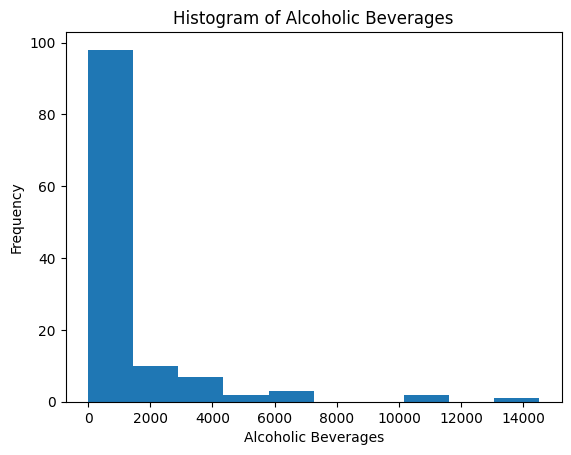

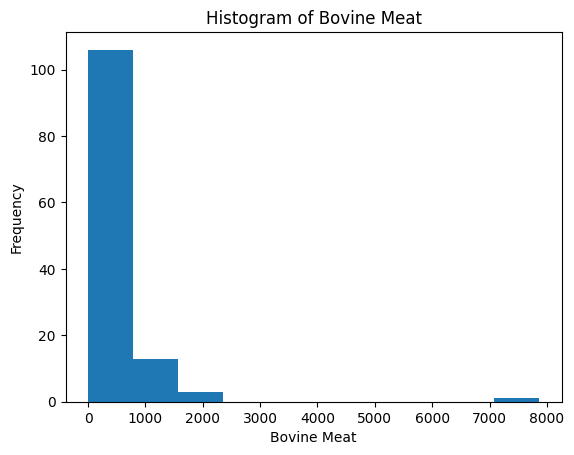

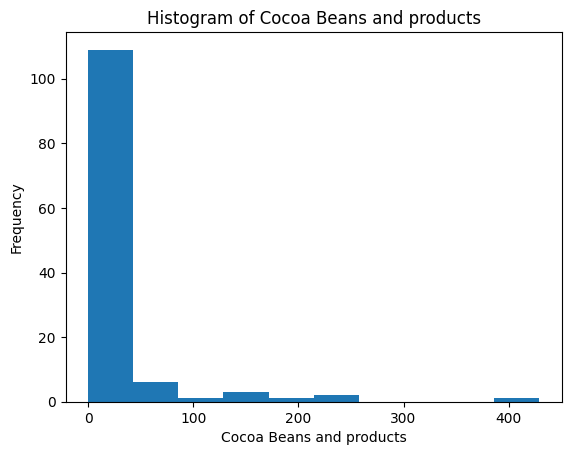

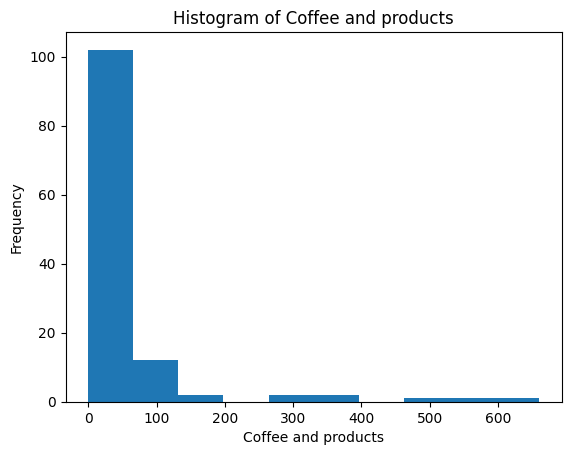

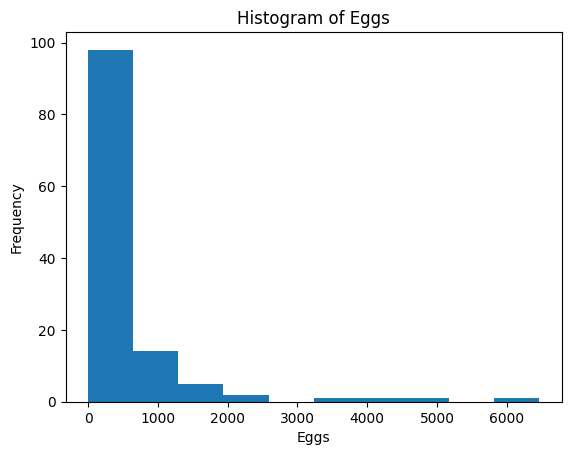

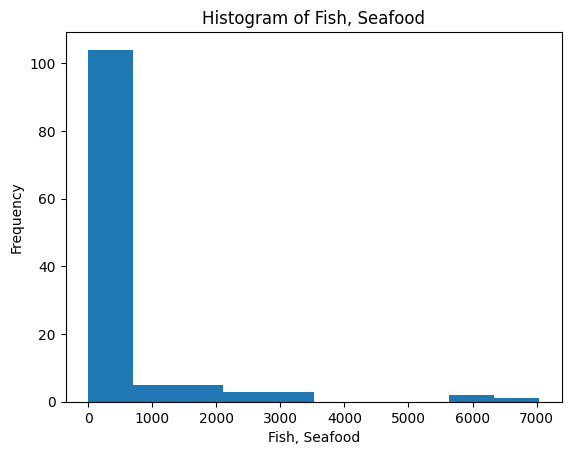

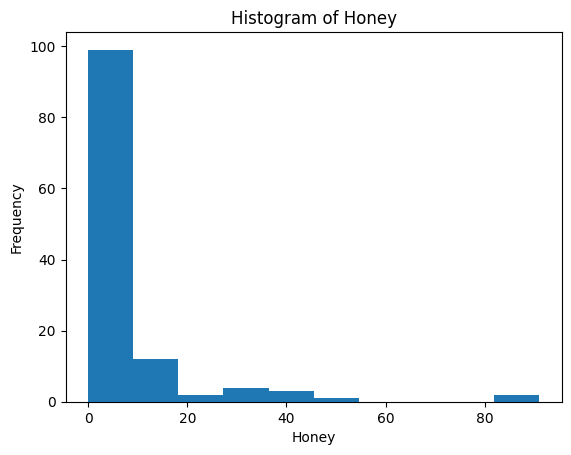

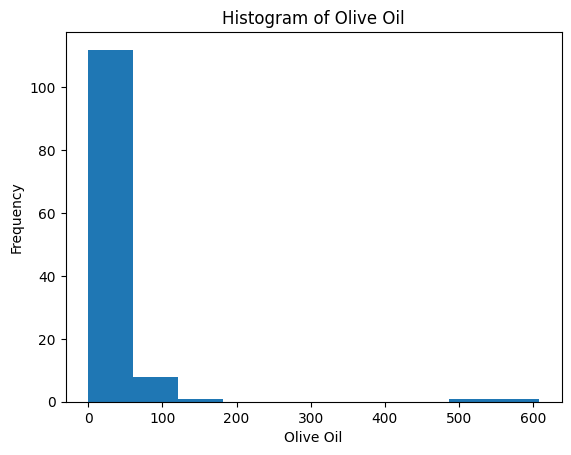

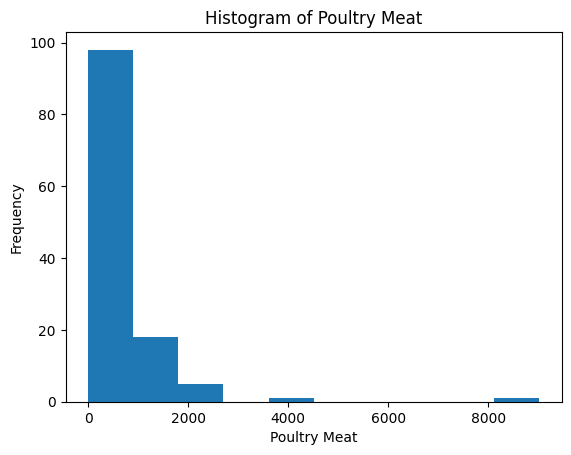

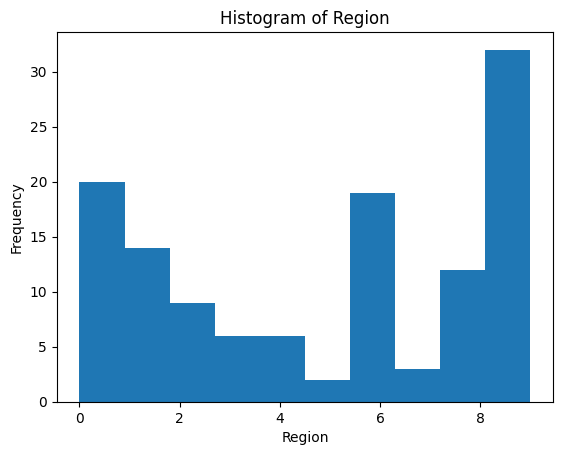

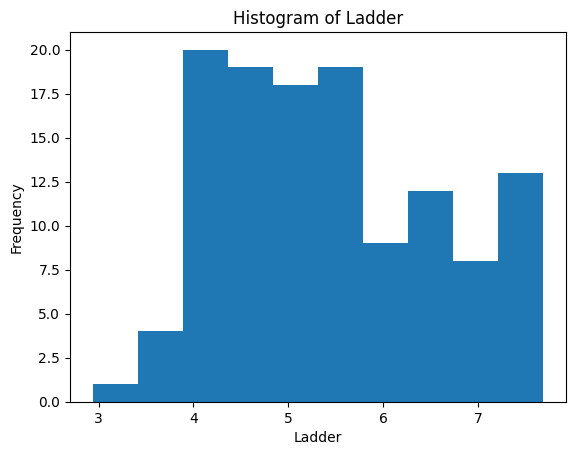

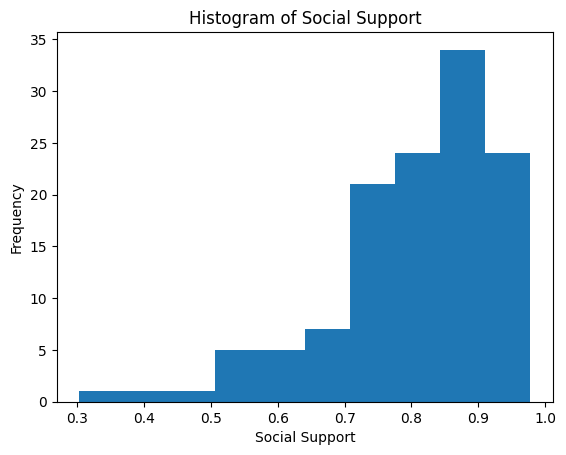

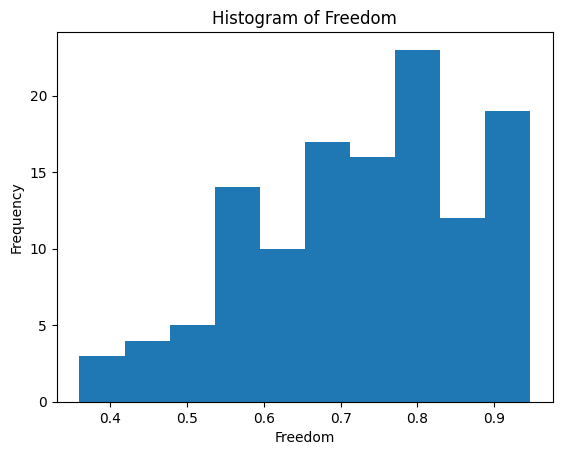

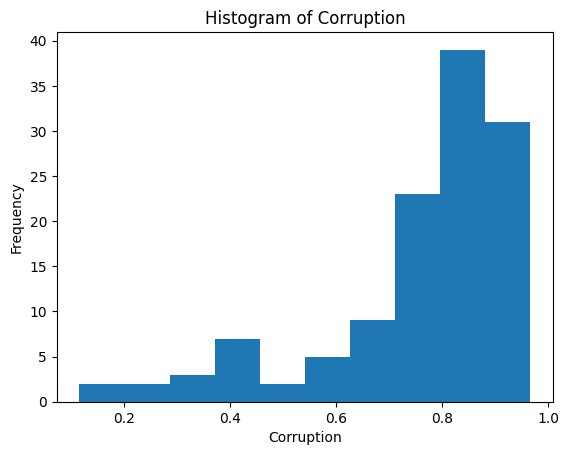

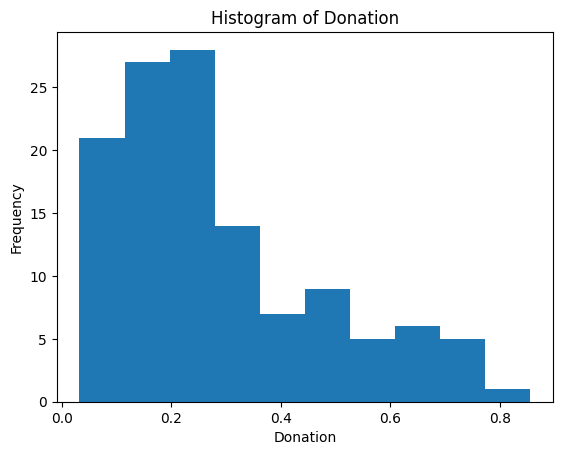

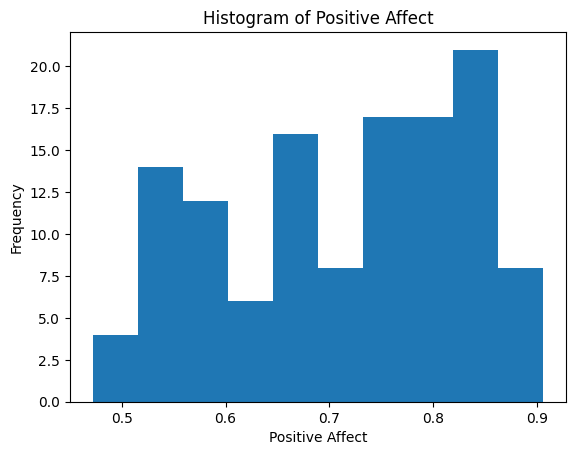

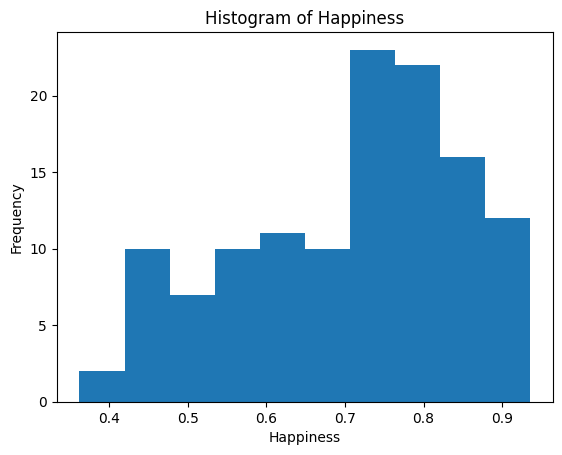

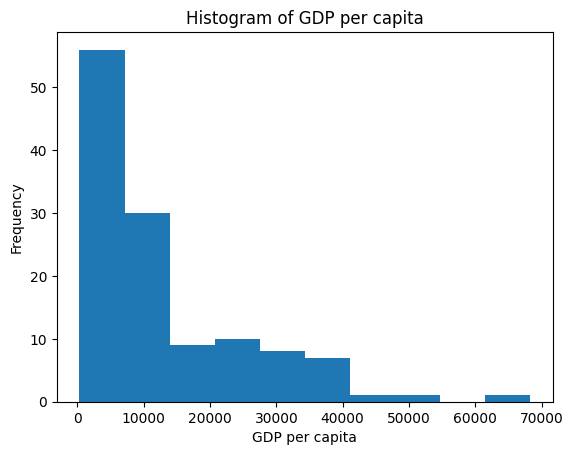

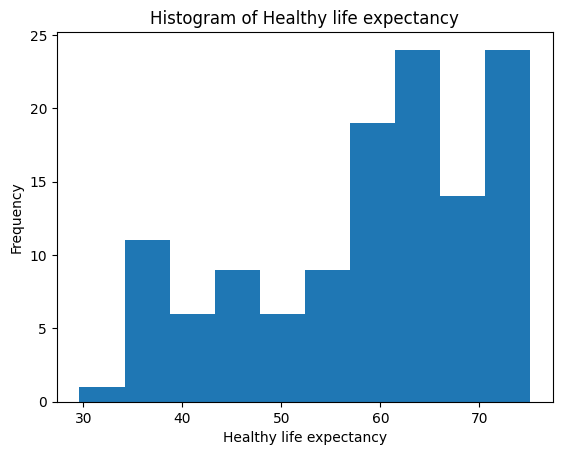

In [ ]:
for column in filtered_df.columns:
    plt.hist(filtered_df[column])
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

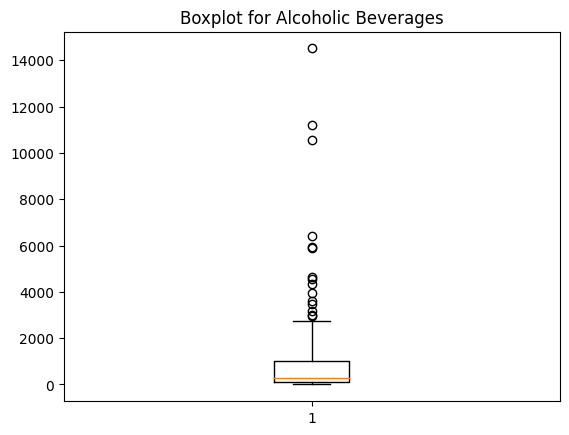

DescribeResult(nobs=123, minmax=(0.0, 14512.0), mean=1142.1463414634147, variance=4904424.240703719, skewness=3.59321408941683, kurtosis=15.092900483461069)


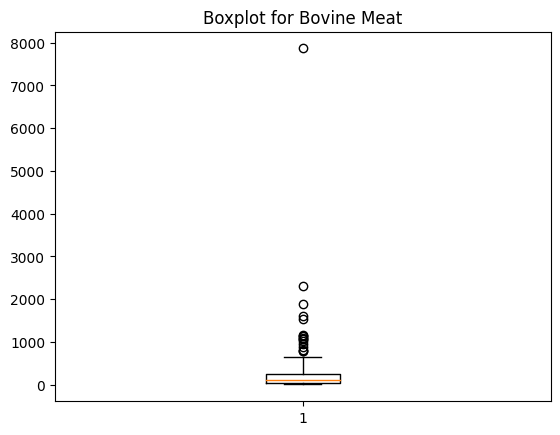

DescribeResult(nobs=123, minmax=(3.0, 7863.0), mean=326.2113821138211, variance=637685.8238038119, skewness=7.204878498844926, kurtosis=63.16355596763819)


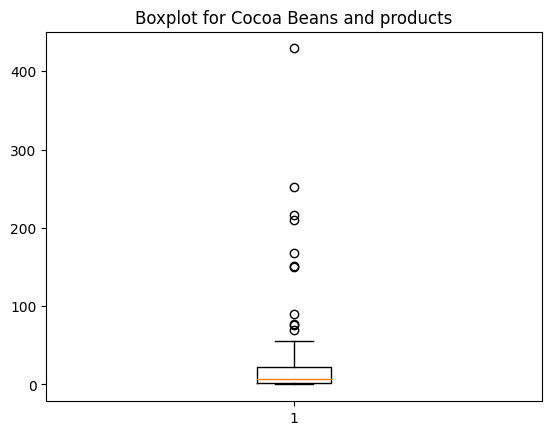

DescribeResult(nobs=123, minmax=(0.0, 429.0), mean=25.097560975609756, variance=3201.8100759696126, skewness=4.4326010150398085, kurtosis=23.383932629031978)


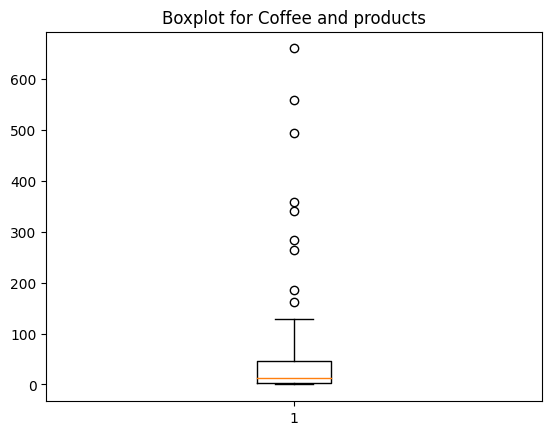

DescribeResult(nobs=123, minmax=(0.0, 660.0), mean=48.21138211382114, variance=10752.151672664268, skewness=3.9016630366882987, kurtosis=16.334607828805133)


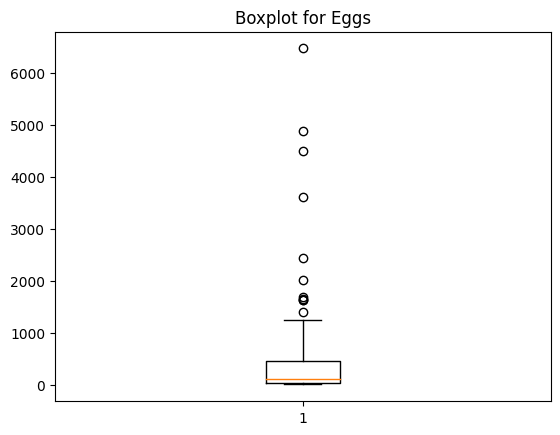

DescribeResult(nobs=123, minmax=(2.0, 6462.0), mean=465.5121951219512, variance=909189.9240303878, skewness=3.9167077097719676, kurtosis=17.596812031692913)


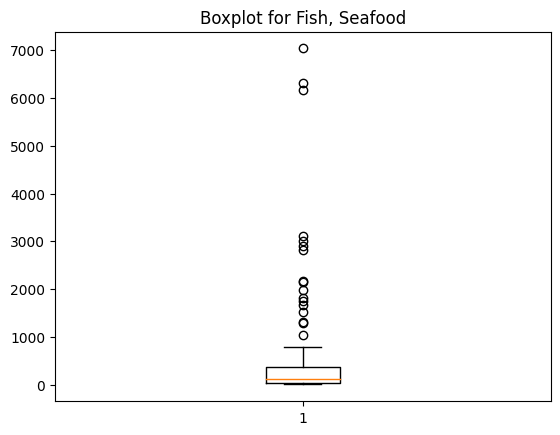

DescribeResult(nobs=123, minmax=(2.0, 7039.0), mean=527.5447154471544, variance=1344150.8729841395, skewness=3.795500462900423, kurtosis=15.789665936646749)


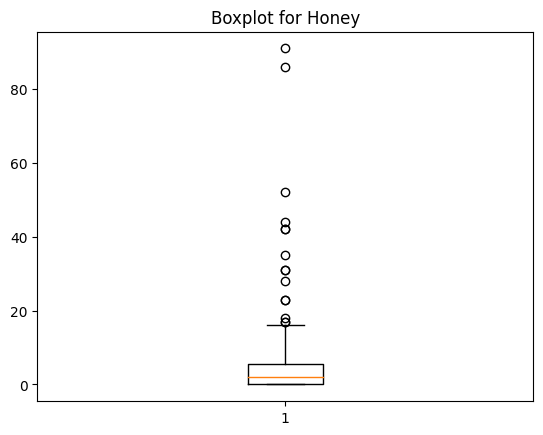

DescribeResult(nobs=123, minmax=(0.0, 91.0), mean=7.130081300813008, variance=210.16326802612284, skewness=3.6657095263838424, kurtosis=15.481378379620363)


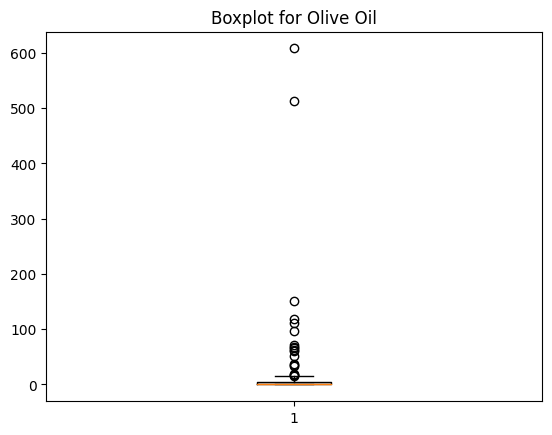

DescribeResult(nobs=123, minmax=(0.0, 608.0), mean=19.276422764227643, variance=5547.054111688658, skewness=6.552235154824118, kurtosis=45.368110538353385)


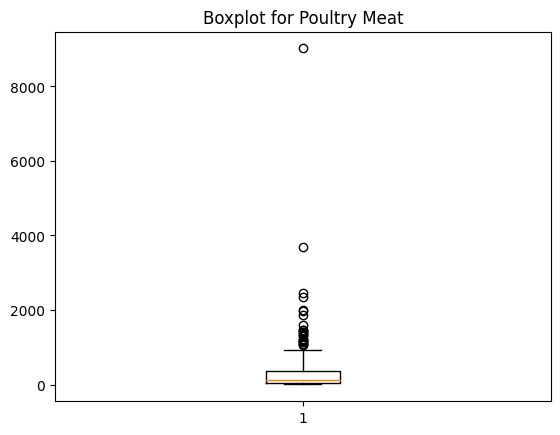

DescribeResult(nobs=123, minmax=(2.0, 9016.0), mean=474.5447154471545, variance=999177.8238038119, skewness=5.6403795079511045, kurtosis=42.37904163173888)


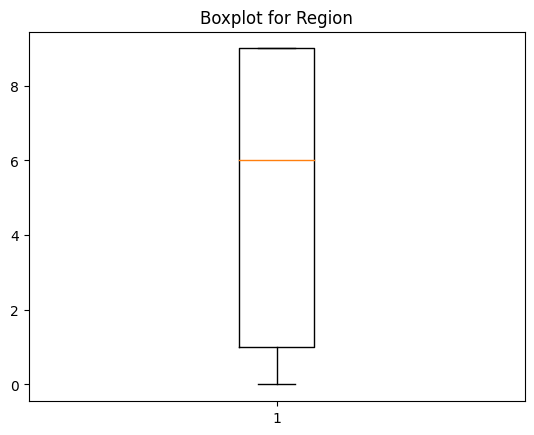

DescribeResult(nobs=123, minmax=(0, 9), mean=4.902439024390244, variance=12.170731707317069, skewness=-0.16346346622779845, kurtosis=-1.5644203951432816)


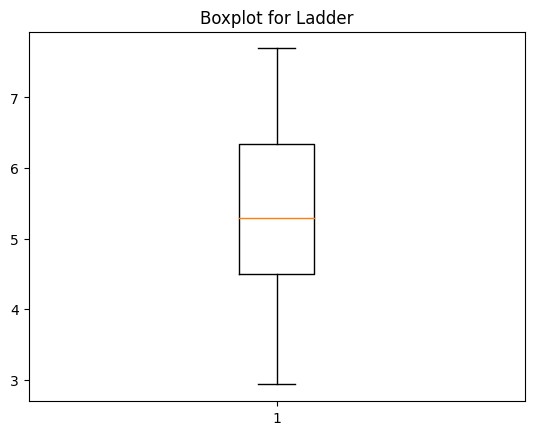

DescribeResult(nobs=123, minmax=(2.936, 7.693), mean=5.432674796747967, variance=1.276018844195655, skewness=0.327285198695578, kurtosis=-0.8247675192813912)


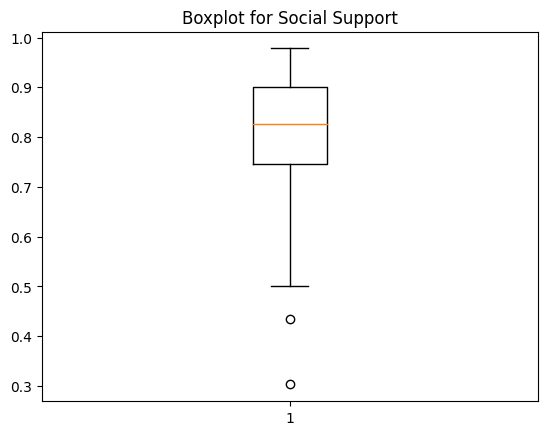

DescribeResult(nobs=123, minmax=(0.303, 0.978), mean=0.8073739837398375, variance=0.015337055711048913, skewness=-1.2496251032798642, kurtosis=1.8495275343626831)


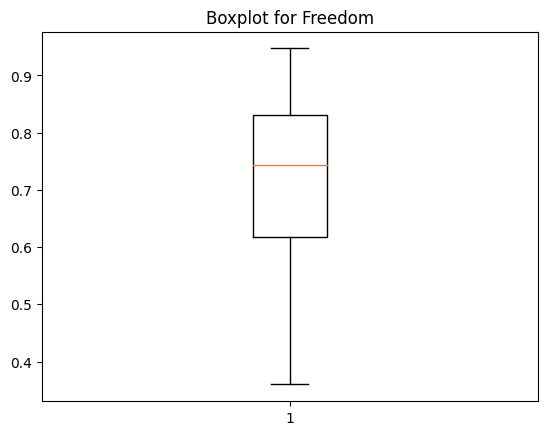

DescribeResult(nobs=123, minmax=(0.36, 0.947), mean=0.7240894308943091, variance=0.01973586898573904, skewness=-0.4045005091035044, kurtosis=-0.4796175223143573)


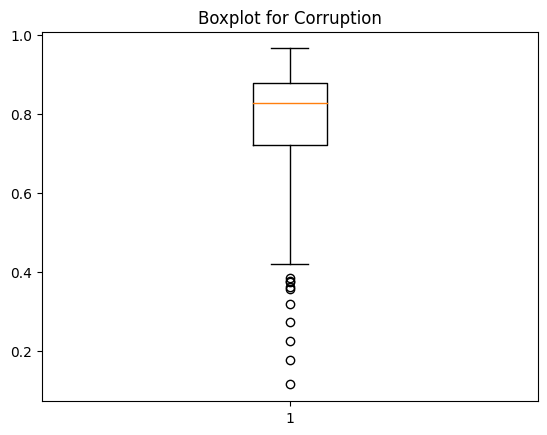

DescribeResult(nobs=123, minmax=(0.115, 0.966), mean=0.7618130081300813, variance=0.03378080900972944, skewness=-1.5218958109802754, kurtosis=1.8511685131116957)


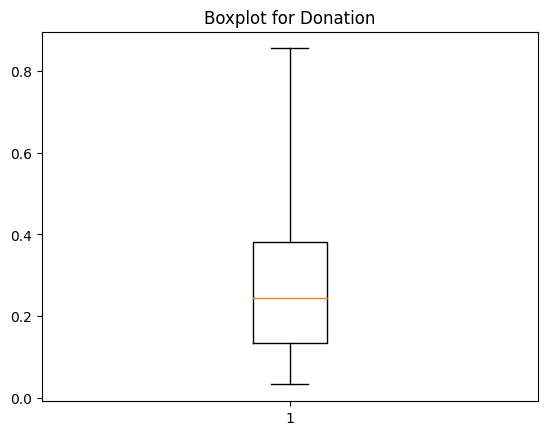

DescribeResult(nobs=123, minmax=(0.032, 0.856), mean=0.2881788617886178, variance=0.03597523004131681, skewness=1.0195837432136328, kurtosis=0.22119309331242087)


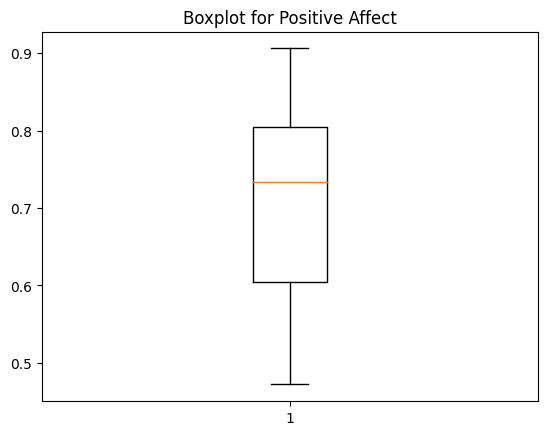

DescribeResult(nobs=123, minmax=(0.472, 0.906), mean=0.7110569105691058, variance=0.013705316406770625, skewness=-0.2771882818821931, kurtosis=-1.1269463979862433)


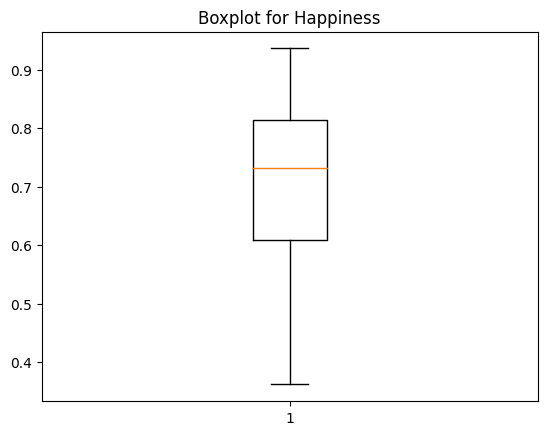

DescribeResult(nobs=123, minmax=(0.362, 0.936), mean=0.7059512195121951, variance=0.019605243502598957, skewness=-0.46077782703471554, kurtosis=-0.7807314350387942)


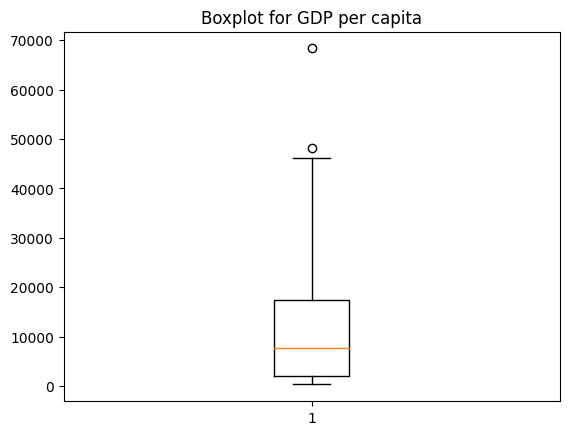

DescribeResult(nobs=123, minmax=(309, 68312), mean=12405.69105691057, variance=165702865.88737836, skewness=1.448628085049204, kurtosis=2.129918222159657)


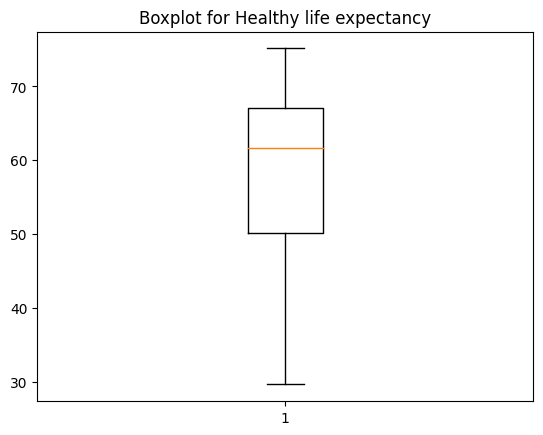

DescribeResult(nobs=123, minmax=(29.616, 75.134), mean=58.67910569105692, variance=134.43813224283616, skewness=-0.6440253524784847, kurtosis=-0.64793968093502)


In [ ]:
for column_name in filtered_df.columns:
    plt.boxplot(filtered_df[column_name], whis = 2)
    plt.title('Boxplot for {}'.format(column_name))
    plt.show()

    print(stats.describe(filtered_df[column_name]))

Checking out the feature distributions and doing transformations on the data below:

In [ ]:
"""
# Specify the columns you want to log transform
columns_to_transform = ['Bovine Meat', 'Eggs', 'Poultry Meat', 'Fish, Seafood', 'Honey', 'Cocoa Beans and products', 'Coffee and products', 'Olive Oil', 'Alcoholic Beverages']

# Make a copy of the DataFrame to avoid modifying the original DataFrame
df_without_outliers = filtered_df.copy()

# Add a small constant to the data to avoid zeros and negative values
small_constant = 1e-8

# Apply log transformation to the specified columns using the copy
df_without_outliers[columns_to_transform] = np.log(df_without_outliers[columns_to_transform] + small_constant)
"""

"\n# Specify the columns you want to log transform\ncolumns_to_transform = ['Bovine Meat', 'Eggs', 'Poultry Meat', 'Fish, Seafood', 'Honey', 'Cocoa Beans and products', 'Coffee and products', 'Olive Oil', 'Alcoholic Beverages']\n\n# Make a copy of the DataFrame to avoid modifying the original DataFrame\ndf_without_outliers = filtered_df.copy()\n\n# Add a small constant to the data to avoid zeros and negative values\nsmall_constant = 1e-8\n\n# Apply log transformation to the specified columns using the copy\ndf_without_outliers[columns_to_transform] = np.log(df_without_outliers[columns_to_transform] + small_constant)\n"

In [ ]:
"""
# Specify the columns you want to log transform
columns_to_transform = ['Healthy life expectancy', 'Happiness', 'Positive Affect', 'Freedom', 'Ladder', 'Donation', 'Corruption', 'Social Support', 'GDP per capita']

df_without_outliers2 = df_without_outliers.copy()

df_without_outliers2[columns_to_transform] += small_constant

lambda_values = {}  # Dictionary to store lambda values for each column

# Apply Box-Cox transformation to the specified columns
for col in columns_to_transform:
    df_without_outliers2[col], lambda_values[col] = boxcox(df_without_outliers2[col])

# Now lambda_values dictionary contains the lambda values for each transformed column
print(lambda_values)
"""

"\n# Specify the columns you want to log transform\ncolumns_to_transform = ['Healthy life expectancy', 'Happiness', 'Positive Affect', 'Freedom', 'Ladder', 'Donation', 'Corruption', 'Social Support', 'GDP per capita']\n\ndf_without_outliers2 = df_without_outliers.copy()\n\ndf_without_outliers2[columns_to_transform] += small_constant\n\nlambda_values = {}  # Dictionary to store lambda values for each column\n\n# Apply Box-Cox transformation to the specified columns\nfor col in columns_to_transform:\n    df_without_outliers2[col], lambda_values[col] = boxcox(df_without_outliers2[col])\n\n# Now lambda_values dictionary contains the lambda values for each transformed column\nprint(lambda_values)\n"

In [ ]:
# NO LONGER NEEDED
"""
def inverse_boxcox(y_transformed, lambda_):
    if lambda_ == 0:
        return np.exp(y_transformed)
    else:
        return np.power((lambda_ * y_transformed + 1), 1 / lambda_)
"""

'\ndef inverse_boxcox(y_transformed, lambda_):\n    if lambda_ == 0:\n        return np.exp(y_transformed)\n    else:\n        return np.power((lambda_ * y_transformed + 1), 1 / lambda_)\n'

In [ ]:
"""
# Now I want to understand how the transformations have affected the relationships between variables.
# This helps me assess the impact of the transformation on the relationships between variables and whether the transformed variables are more suitable for my analysis.

correlation_matrix = df_without_outliers2.corr()

# Correlation of healthy life expectancy with other features
health_correlation = correlation_matrix['Healthy life expectancy']

print("Correlation of healthy life expectancy with other (transformed) features:")
print(health_correlation)
"""

'\n# Now I want to understand how the transformations have affected the relationships between variables.\n# This helps me assess the impact of the transformation on the relationships between variables and whether the transformed variables are more suitable for my analysis.\n\ncorrelation_matrix = df_without_outliers2.corr()\n\n# Correlation of healthy life expectancy with other features\nhealth_correlation = correlation_matrix[\'Healthy life expectancy\']\n\nprint("Correlation of healthy life expectancy with other (transformed) features:")\nprint(health_correlation)\n'

I decided not to transform any features as the models MSE performed significantly better without doing so.

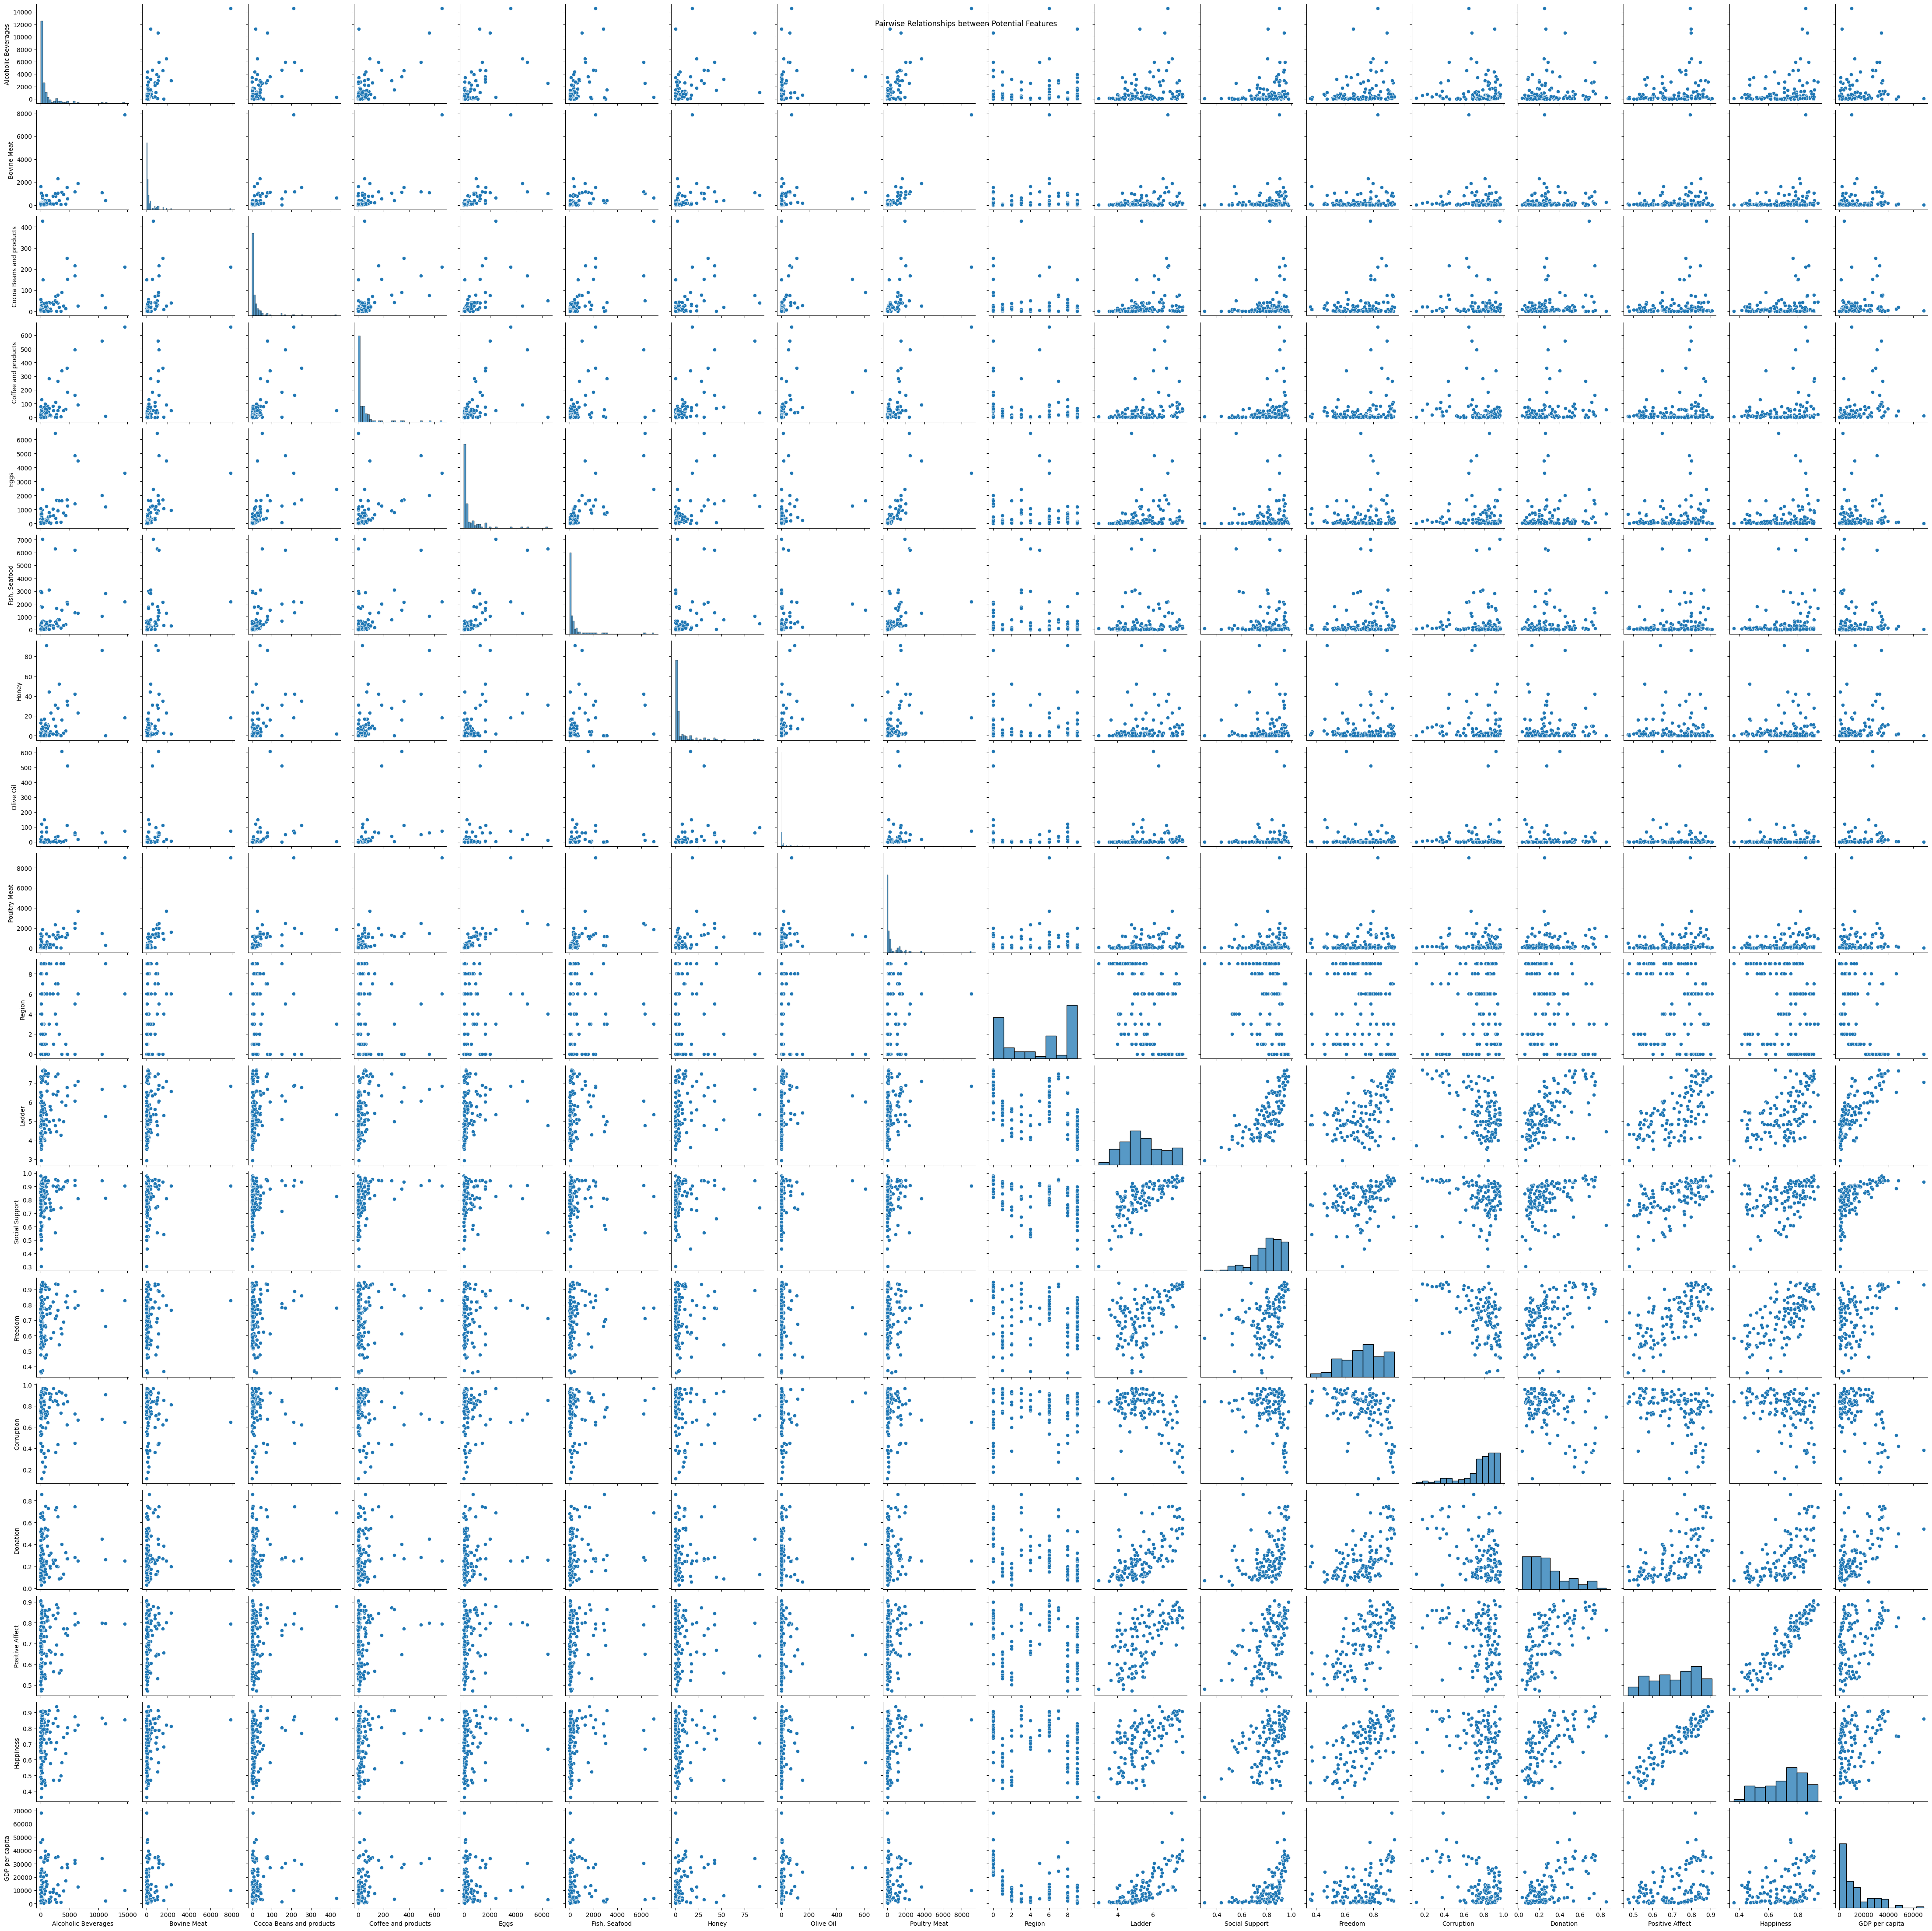

In [ ]:
# Checking relationships between features
sns.pairplot(filtered_df.drop(['Healthy life expectancy'], axis=1))
plt.suptitle('Pairwise Relationships between Potential Features')
plt.show()

In [ ]:
filtered_df.shape[0]

123

Below I prepare my training and testing X & y datasets for model consumption.

In [ ]:
# Define independent (X) and dependent (y) variables
X = filtered_df.drop(['Healthy life expectancy'], axis=1) # Independent variable(s)
y = filtered_df['Healthy life expectancy'] # Dependent variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regression Model

In [ ]:
# Create a LinearRegression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

# Evaluate the model
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print("Training R^2 Score:", train_score)
print("Testing R^2 Score:", test_score)
print("Training RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)
# print("Training RMSE:", inverse_boxcox(train_rmse, lambda_values.get('Healthy life expectancy')))
# print("Testing RMSE:", inverse_boxcox(test_rmse, lambda_values.get('Healthy life expectancy')))


Training R^2 Score: 0.7853781325601381
Testing R^2 Score: 0.6735757170244292
Training RMSE: 5.4082614845911285
Testing RMSE: 5.961496533390718


Here I attempt to pedict the life expectancy for the United Arab Emirates using the linear regression model I just trained.

In [ ]:
# NO LONGER NEEDED
"""
# Function to apply Box-Cox transformation
def apply_boxcox(x, lambda_value):
    if lambda_value == 0:
        return np.log(x)
    else:
        return (x**lambda_value - 1) / lambda_value
"""

'\n# Function to apply Box-Cox transformation\ndef apply_boxcox(x, lambda_value):\n    if lambda_value == 0:\n        return np.log(x)\n    else:\n        return (x**lambda_value - 1) / lambda_value\n'

In [ ]:
uae_features = {
    'Alcoholic Beverages': 0,
    'Bovine Meat': 53,
    'Cocoa Beans and products': 7,
    'Coffee and products': 28,
    'Eggs': 154,
    'Fish, Seafood': 213,
    'Honey': 2,
    'Olive Oil': 4,
    'Poultry Meat': 384,
    'Region': 8,
    'Ladder': 7.144,
    'Social Support': 0.878,
    'Freedom': 0.895,
    'Corruption': 0.355,
    'Donation': 0.472,
    'Positive Affect': 0.765,
    'Happiness': 0.764,
    'GDP per capita': 43295
}

"""
uae_features = {
    'Alcoholic Beverages': np.log(0 + small_constant),
    'Bovine Meat': np.log(53 + small_constant),
    'Cocoa Beans and products': np.log(7 + small_constant),
    'Coffee and products': np.log(28 + small_constant),
    'Eggs': np.log(154 + small_constant),
    'Fish, Seafood': np.log(213 + small_constant),
    'Honey': np.log(2 + small_constant),
    'Olive Oil': np.log(4 + small_constant),
    'Poultry Meat': np.log(384 + small_constant),
    'Region': 8,
    'Ladder': apply_boxcox(7.144 + small_constant, lambda_values.get('Ladder')),
    'Social Support': apply_boxcox(0.878 + small_constant, lambda_values.get('Social Support')),
    'Freedom': apply_boxcox(0.895 + small_constant, lambda_values.get('Freedom')),
    'Corruption': apply_boxcox(0.355 + small_constant, lambda_values.get('Corruption')),
    'Donation': apply_boxcox(0.472 + small_constant, lambda_values.get('Donation')),
    'Positive Affect': apply_boxcox(0.765 + small_constant, lambda_values.get('Positive Affect')),
    'Happiness': apply_boxcox(0.764 + small_constant, lambda_values.get('Happiness')),
    'GDP per capita': apply_boxcox(43295 + small_constant, lambda_values.get('GDP per capita'))
}
"""

# Convert the dictionary to a DataFrame
uae_df = pd.DataFrame(uae_features, index=[0])

# Predict the healthy life expectancy
uae_predicted_health = model.predict(uae_df)

BOX_uae_predicted_health = uae_predicted_health[0]

In [ ]:
print("Predicted healthy life expectancy for the United Arab Emirates:", BOX_uae_predicted_health)
# print("Predicted healthy life expectancy for the United Arab Emirates:", inverse_boxcox(BOX_uae_predicted_health, lambda_values.get('Healthy life expectancy')))

Predicted healthy life expectancy for the United Arab Emirates: 65.05242763042776


I then go on to try out a random forest model, tunning hyperparameters as I test.

# Random Forest Model

In [ ]:
# Define the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameters grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
rf_best = RandomForestRegressor(random_state=42, **best_params)
rf_best.fit(X_train, y_train)

# Make predictions
y_train_pred = rf_best.predict(X_train)
y_test_pred = rf_best.predict(X_test)

# Calculate R^2 scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Best hyperparameters:", best_params)
print("Train R^2 score:", train_r2)
print("Test R^2 score:", test_r2)
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
# print("Train RMSE:", inverse_boxcox(train_rmse, lambda_values.get('Healthy life expectancy')))
# print("Test RMSE:", inverse_boxcox(test_rmse, lambda_values.get('Healthy life expectancy')))

Best hyperparameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Train R^2 score: 0.9398666553209003
Test R^2 score: 0.7675160552622347
Train RMSE: 2.862716734226368
Test RMSE: 5.031072194281693


In [ ]:
# Predict the healthy life expectancy
uae_predicted_health = rf_best.predict(uae_df)

BOX_uae_predicted_health = uae_predicted_health[0]

# print("Predicted healthy life expectancy for the United Arab Emirates:", inverse_boxcox(BOX_uae_predicted_health, lambda_values.get('Healthy life expectancy')))
print("Predicted healthy life expectancy for the United Arab Emirates:", BOX_uae_predicted_health)

Predicted healthy life expectancy for the United Arab Emirates: 69.12061275468324


The real value should be around 64.545 years old. Both models are pretty close!

After evaluating the performance of both the linear regression and random forest models, it is evident that the random forest model outperforms the linear regression model in predicting healthy life expectancy. The random forest model achieved higher R-squared (R^2) scores on both the training and testing datasets, indicating a better fit to the data and capturing a larger proportion of the variance in the target variable. Additionally, the random forest model demonstrated lower root mean squared error (RMSE) values for both training and testing datasets, signifying more accurate predictions on average.

Considering the potential non-linear relationships and complex interactions among the features and the target variable, the limitations of linear regression in capturing such complexities become apparent. The inherent flexibility of the random forest algorithm allows it to effectively capture non-linear relationships and interactions among features without imposing strict linear assumptions. Therefore, based on the superior performance in terms of predictive accuracy and flexibility in handling non-linearity, the random forest model emerges as the preferred choice for this dataset.

Next time, if time allowed me, I would have liked to do some PCA before running the data through the models!